## Summary:

Mark, votre manager, vous a convié à une réunion pour vous présenter le projet d’expansion à l’international de l’entreprise. Il vous confie une première mission d’analyse exploratoire, pour déterminer si les données sur l’éducation de la banque mondiale permettent d’informer le projet d’expansion.

Voici les différentes questions que Mark aimerait explorer, que vous avez notées durant la réunion :

Quels sont les pays avec un fort potentiel de clients pour nos services ?
Pour chacun de ces pays, quelle sera l’évolution de ce potentiel de clients ?
Dans quels pays l'entreprise doit-elle opérer en priorité ?


Votre mission
Mark vous a donc demandé de réaliser une analyse pré-exploratoire de ce jeu de données. Il vous a transmis cet email à la suite de la réunion :

Hello,

Les données de la Banque mondiale sont disponibles à l’adresse suivante :

https://datacatalog.worldbank.org/dataset/education-statistics

Ou en téléchargement direct à ce lien.

Je te laisse regarder la page d'accueil qui décrit le jeu de données. En résumé, l’organisme “EdStats All Indicator Query” de la Banque mondiale répertorie 4000 indicateurs internationaux décrivant l’accès à l’éducation, l’obtention de diplômes et des informations relatives aux professeurs, aux dépenses liées à l’éducation... Tu trouveras plus d'info sur ce site :

http://datatopics.worldbank.org/education/

Pour la pré-analyse, pourrais-tu :

Valider la qualité de ce jeu de données (comporte-t-il beaucoup de données manquantes, dupliquées ?)
Décrire les informations contenues dans le jeu de données (nombre de colonnes ? nombre de lignes ?)
Sélectionner les informations qui semblent pertinentes pour répondre à la problématique (quelles sont les colonnes contenant des informations qui peuvent être utiles pour répondre à la problématique de l’entreprise ?)
Déterminer des ordres de grandeurs des indicateurs statistiques classiques pour les différentes zones géographiques et pays du monde (moyenne/médiane/écart-type par pays et par continent ou bloc géographique)
Ton travail va nous permettre de déterminer si ce jeu de données peut informer les décisions d'ouverture vers de nouveaux pays. On va partager ton analyse avec le board, alors merci de soigner la présentation et de l'illustrer avec des graphiques pertinents et lisibles !

Livrables attendus
Un notebook comportant les analyses pré-exploratoires réalisées (non cleané, pour comprendre votre démarche).


source data: https://datacatalog.worldbank.org/search/dataset/0038480

## Import Librairies

In [1]:
%matplotlib inline
import re
from os import path, getenv, environ
from typing import Dict

import folium
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import plotly.express as px
import scipy.stats as stats
import seaborn as sns
from sklearn import set_config
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler


set_config(display="diagram", print_changed_only=False)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [61]:
!PWD

/Users/mouslydiaw/ensae_project/courses/python_crash_course/excercice


In [3]:
ROOT_DIR = path.dirname(path.realpath("__file__"))

ROOT_DIR

'/Users/mouslydiaw/ensae_project/courses/python_crash_course/excercice'

## Load data

In [4]:
filepath = path.join(ROOT_DIR, "data", "education_stats.csv")
data = pd.read_csv(filepath, sep=";")
print("Data shape: {shape}".format(shape=data.shape))

Data shape: (2904, 30)


In [5]:
data.head()

Country Name Country Code  \
0   Arab World          ARB   
1   Arab World          ARB   
2   Arab World          ARB   
3   Arab World          ARB   
4   Arab World          ARB   

                                                                    Indicator Name  \
0                Expenditure on education as % of total government expenditure (%)   
1                              GDP per capita, PPP (constant 2011 international $)   
2  Government expenditure on post-secondary non-tertiary education as % of GDP (%)   
3                    Government expenditure on secondary education as % of GDP (%)   
4                     Government expenditure on tertiary education as % of GDP (%)   

      Indicator Code         2020  Short Name  Table Name   Long Name  \
0  SE.XPD.TOTL.GB.ZS          NaN  Arab World  Arab World  Arab World   
1  NY.GDP.PCAP.PP.KD  11450.86079  Arab World  Arab World  Arab World   
2   UIS.XGDP.4.FSGOV          NaN  Arab World  Arab World  Arab World   
3  UIS.XGDP.23.FSGOV          NaN  Arab World  Arab World  Arab World   
4  UIS.XGDP.56.FSGOV          NaN  Arab World  Arab World  Arab World   

  2-alpha code Currency Unit  \
0           1A           NaN   
1           1A           NaN   
2           1A           NaN   
3           1A           NaN   
4           1A           NaN   

                                                                           Special Notes  \
0  Arab World aggregate. Arab World is composed of members of the League of Arab States.   
1  Arab World aggregate. Arab World is composed of members of the League of Arab States.   
2  Arab World aggregate. Arab World is composed of members of the League of Arab States.   
3  Arab World aggregate. Arab World is composed of members of the League of Arab States.   
4  Arab World aggregate. Arab World is composed of members of the League of Arab States.   

  Region Income Group WB-2 code System of National Accounts  \
0    NaN          NaN        1A                         NaN   
1    NaN          NaN        1A                         NaN   
2    NaN          NaN        1A                         NaN   
3    NaN          NaN        1A                         NaN   
4    NaN          NaN        1A                         NaN   

  Alternative conversion factor PPP survey year        Series Code  \
0                           NaN             NaN  SE.XPD.TOTL.GB.ZS   
1                           NaN             NaN  NY.GDP.PCAP.PP.KD   
2                           NaN             NaN   UIS.XGDP.4.FSGOV   
3                           NaN             NaN  UIS.XGDP.23.FSGOV   
4                           NaN             NaN  UIS.XGDP.56.FSGOV   

                                             Topic Short definition  \
0                                     Expenditures              NaN   
1  Economic Policy & Debt: Purchasing power parity              NaN   
2                                     Expenditures              NaN   
3                                     Expenditures              NaN   
4                                     Expenditures              NaN   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

## EDA & Data pre-processing

### Dataframe summary

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2904 entries, 0 to 2903
Data columns (total 30 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Country Name                   2904 non-null   object 
 1   Country Code                   2904 non-null   object 
 2   Indicator Name                 2904 non-null   object 
 3   Indicator Code                 2904 non-null   object 
 4   2020                           1588 non-null   float64
 5   Short Name                     2892 non-null   object 
 6   Table Name                     2892 non-null   object 
 7   Long Name                      2892 non-null   object 
 8   2-alpha code                   2856 non-null   object 
 9   Currency Unit                  2580 non-null   object 
 10  Special Notes                  1740 non-null   object 
 11  Region                         2568 non-null   object 
 12  Income Group                   2568 non-null   o

In [7]:
data.describe(include="all")

Country Name Country Code  \
count                     2904         2904   
unique                     242          242   
top     British Virgin Islands          CRI   
freq                        12           12   
mean                       NaN          NaN   
std                        NaN          NaN   
min                        NaN          NaN   
25%                        NaN          NaN   
50%                        NaN          NaN   
75%                        NaN          NaN   
max                        NaN          NaN   

                                                Indicator Name  \
count                                                     2904   
unique                                                      12   
top     Gross enrolment ratio, upper secondary, both sexes (%)   
freq                                                       242   
mean                                                       NaN   
std                                                        NaN   
min                                                        NaN   
25%                                                        NaN   
50%                                                        NaN   
75%                                                        NaN   
max                                                        NaN   

            Indicator Code          2020 Short Name Table Name  Long Name  \
count                 2904  1.588000e+03       2892       2892       2892   
unique                  12           NaN        241        241        241   
top     UIS.EA.3T6.AG25T99           NaN       Chad  Gibraltar  Gibraltar   
freq                   242           NaN         12         12         12   
mean                   NaN  2.592391e+07        NaN        NaN        NaN   
std                    NaN  2.664621e+08        NaN        NaN        NaN   
min                    NaN  0.000000e+00        NaN        NaN        NaN   
25%                    NaN  6.537010e+00        NaN        NaN        NaN   
50%                    NaN  5.044388e+01        NaN        NaN        NaN   
75%                    NaN  2.746509e+03        NaN        NaN        NaN   
max                    NaN  6.118075e+09        NaN        NaN        NaN   

       2-alpha code Currency Unit  \
count          2856          2580   
unique          238           152   
top              OM          Euro   
freq             12           276   
mean            NaN           NaN   
std             NaN           NaN   
min             NaN           NaN   
25%             NaN           NaN   
50%             NaN           NaN   
75%             NaN           NaN   
max             NaN           NaN   

                                                                                                                                                   Special Notes  \
count                                                                                                                                                       1740   
unique                                                                                                                                                       131   
top     April 2012 database update: Based on official government statistics, national accounts data were revised for 2000 onward; the base year changed to 2006.   
freq                                                                                                                                                          72   
mean                                                                                                                                                         NaN   
std                                                                                                                                                          NaN   
min                                                                                                                                           

### Rename columns

In [8]:
# Rename columns: replace space & - by _
data.columns = data.columns.str.lower().str.replace('[-\s]', '_', regex=True)
data.head()

country_name country_code  \
0   Arab World          ARB   
1   Arab World          ARB   
2   Arab World          ARB   
3   Arab World          ARB   
4   Arab World          ARB   

                                                                    indicator_name  \
0                Expenditure on education as % of total government expenditure (%)   
1                              GDP per capita, PPP (constant 2011 international $)   
2  Government expenditure on post-secondary non-tertiary education as % of GDP (%)   
3                    Government expenditure on secondary education as % of GDP (%)   
4                     Government expenditure on tertiary education as % of GDP (%)   

      indicator_code         2020  short_name  table_name   long_name  \
0  SE.XPD.TOTL.GB.ZS          NaN  Arab World  Arab World  Arab World   
1  NY.GDP.PCAP.PP.KD  11450.86079  Arab World  Arab World  Arab World   
2   UIS.XGDP.4.FSGOV          NaN  Arab World  Arab World  Arab World   
3  UIS.XGDP.23.FSGOV          NaN  Arab World  Arab World  Arab World   
4  UIS.XGDP.56.FSGOV          NaN  Arab World  Arab World  Arab World   

  2_alpha_code currency_unit  \
0           1A           NaN   
1           1A           NaN   
2           1A           NaN   
3           1A           NaN   
4           1A           NaN   

                                                                           special_notes  \
0  Arab World aggregate. Arab World is composed of members of the League of Arab States.   
1  Arab World aggregate. Arab World is composed of members of the League of Arab States.   
2  Arab World aggregate. Arab World is composed of members of the League of Arab States.   
3  Arab World aggregate. Arab World is composed of members of the League of Arab States.   
4  Arab World aggregate. Arab World is composed of members of the League of Arab States.   

  region income_group wb_2_code system_of_national_accounts  \
0    NaN          NaN        1A                         NaN   
1    NaN          NaN        1A                         NaN   
2    NaN          NaN        1A                         NaN   
3    NaN          NaN        1A                         NaN   
4    NaN          NaN        1A                         NaN   

  alternative_conversion_factor ppp_survey_year        series_code  \
0                           NaN             NaN  SE.XPD.TOTL.GB.ZS   
1                           NaN             NaN  NY.GDP.PCAP.PP.KD   
2                           NaN             NaN   UIS.XGDP.4.FSGOV   
3                           NaN             NaN  UIS.XGDP.23.FSGOV   
4                           NaN             NaN  UIS.XGDP.56.FSGOV   

                                             topic short_definition  \
0                                     Expenditures              NaN   
1  Economic Policy & Debt: Purchasing power parity              NaN   
2                                     Expenditures              NaN   
3                                     Expenditures              NaN   
4                                     Expenditures              NaN   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

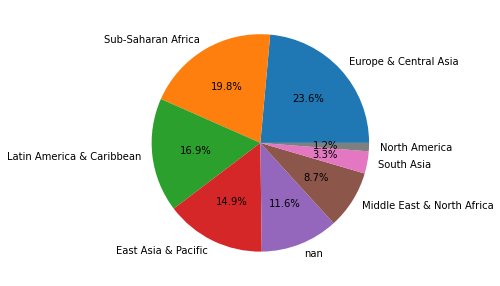

In [9]:
# region
(data.region
 .value_counts(dropna=False)
 .plot(kind="pie", autopct='%.1f%%', legend = False, fontsize=10,
      xlabel="", ylabel="", table=False, figsize=(5, 5))
);

In [10]:
data.loc[data.region.isnull(), "country_name"].unique()

array(['Arab World', 'East Asia & Pacific',
       'East Asia & Pacific (excluding high income)', 'Euro area',
       'Europe & Central Asia',
       'Europe & Central Asia (excluding high income)', 'European Union',
       'Heavily indebted poor countries (HIPC)', 'High income',
       'Latin America & Caribbean',
       'Latin America & Caribbean (excluding high income)',
       'Least developed countries: UN classification',
       'Low & middle income', 'Low income', 'Lower middle income',
       'Middle East & North Africa',
       'Middle East & North Africa (excluding high income)',
       'Middle income', 'North America', 'OECD members', 'South Asia',
       'Sub-Saharan Africa', 'Sub-Saharan Africa (excluding high income)',
       'Upper middle income', 'World', 'British Virgin Islands',
       'Gibraltar', 'Nauru'], dtype=object)

### Filtering

#### Delete country with missing region

In [11]:
# delete all rows which have a missing region
data = data.loc[data.region.notnull()]

In [12]:
data.describe(include="all")

country_name country_code     indicator_name      indicator_code  \
count          2568         2568               2568                2568   
unique          214          214                 12                  12   
top         Albania          CRI  Population, total  UIS.EA.3T6.AG25T99   
freq             12           12                214                 214   
mean            NaN          NaN                NaN                 NaN   
std             NaN          NaN                NaN                 NaN   
min             NaN          NaN                NaN                 NaN   
25%             NaN          NaN                NaN                 NaN   
50%             NaN          NaN                NaN                 NaN   
75%             NaN          NaN                NaN                 NaN   
max             NaN          NaN                NaN                 NaN   

                2020 short_name table_name  \
count   1.436000e+03       2568       2568   
unique           NaN        214        214   
top              NaN    Albania    Albania   
freq             NaN         12         12   
mean    4.246925e+06        NaN        NaN   
std     4.586961e+07        NaN        NaN   
min     0.000000e+00        NaN        NaN   
25%     5.699508e+00        NaN        NaN   
50%     4.871977e+01        NaN        NaN   
75%     2.327380e+03        NaN        NaN   
max     1.262645e+09        NaN        NaN   

                                      long_name 2_alpha_code currency_unit  \
count                                      2568         2532          2568   
unique                                      214          211           151   
top     People's Democratic Republic of Algeria           DM          Euro   
freq                                         12           12           276   
mean                                        NaN          NaN           NaN   
std                                         NaN          NaN           NaN   
min                                         NaN          NaN           NaN   
25%                                         NaN          NaN           NaN   
50%                                         NaN          NaN           NaN   
75%                                         NaN          NaN           NaN   
max                                         NaN          NaN           NaN   

                                                                                                                                                   special_notes  \
count                                                                                                                                                       1440   
unique                                                                                                                                                       106   
top     April 2012 database update: Based on official government statistics, national accounts data were revised for 2000 onward; the base year changed to 2006.   
freq                                                                                                                                                          72   
mean                                                                                                                                                         NaN   
std                                                                                                                                                          NaN   
min                                                                                                                                                          NaN   
25%                                                                                                                                                          NaN   
50%                                                                                                                                         

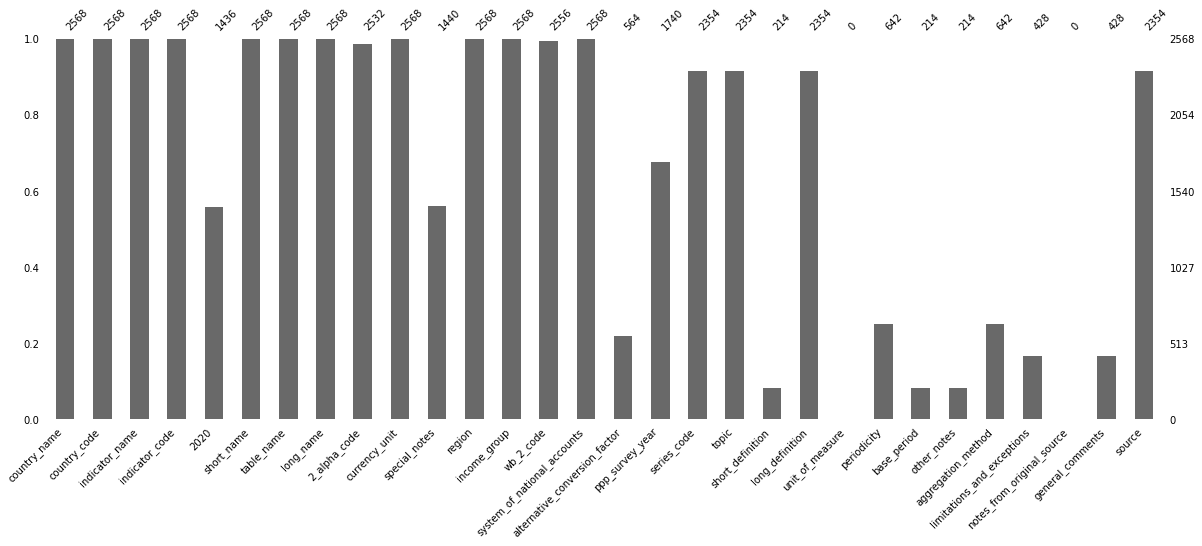

In [13]:
msno.bar(data, figsize=(20, 7), fontsize=10);

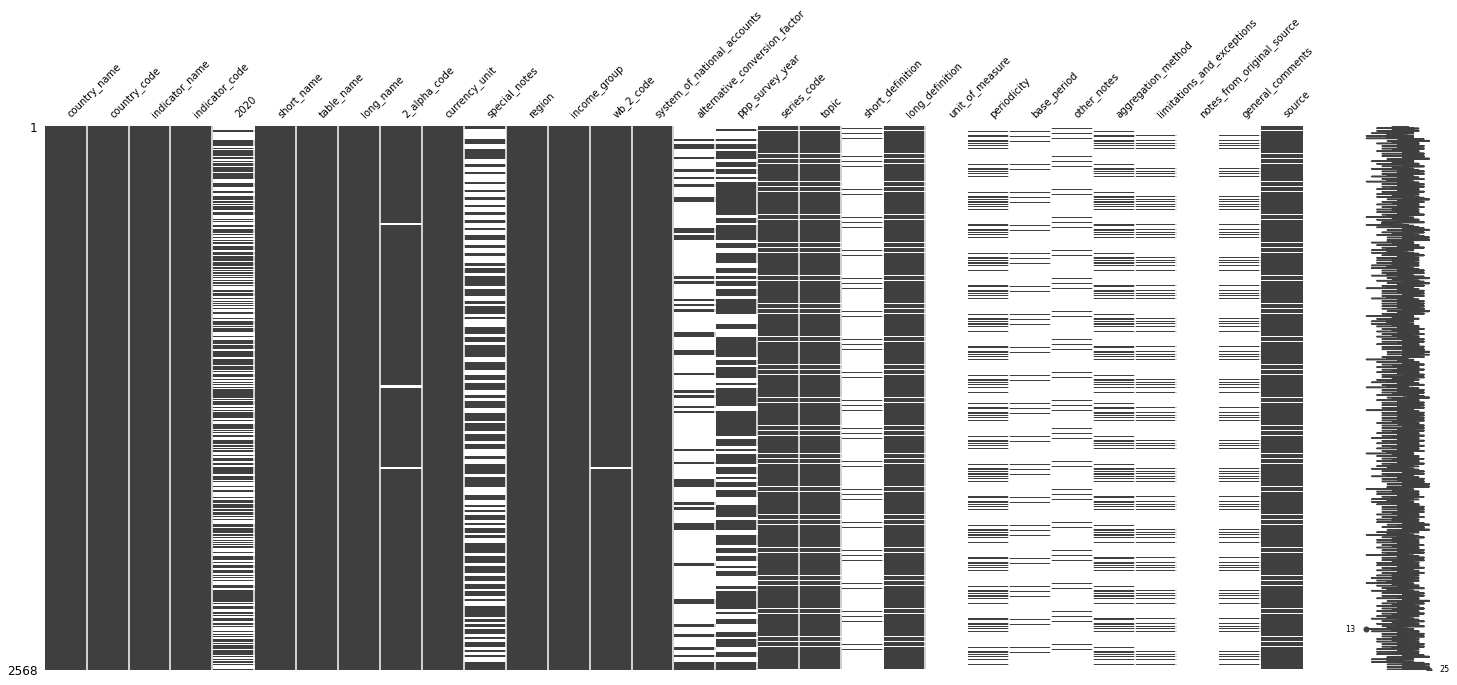

In [14]:
msno.matrix(data, figsize=(25, 10), fontsize=10);

#### Delete Low income group

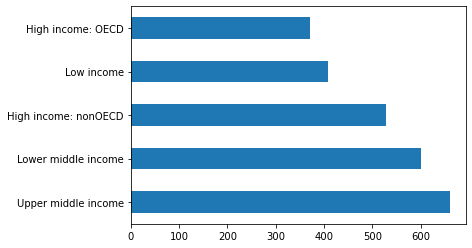

In [15]:
### income group
data.income_group.value_counts().plot(kind="barh");

In [16]:
# filter low income group

LOW_INCOME_FILTER = data.income_group.str.contains("low", regex=True, flags=re.I, na=False)
data.loc[LOW_INCOME_FILTER, "country_name"].unique()

array(['Afghanistan', 'Armenia', 'Bangladesh', 'Benin', 'Bhutan',
       'Bolivia', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia',
       'Cameroon', 'Central African Republic', 'Chad', 'Comoros',
       'Congo, Dem. Rep.', 'Congo, Rep.', "Cote d'Ivoire", 'Djibouti',
       'Egypt, Arab Rep.', 'El Salvador', 'Eritrea', 'Ethiopia',
       'Gambia, The', 'Georgia', 'Ghana', 'Guatemala', 'Guinea',
       'Guinea-Bissau', 'Guyana', 'Haiti', 'Honduras', 'India',
       'Indonesia', 'Kenya', 'Kiribati', 'Korea, Dem. People’s Rep.',
       'Kosovo', 'Kyrgyz Republic', 'Lao PDR', 'Lesotho', 'Liberia',
       'Madagascar', 'Malawi', 'Mali', 'Mauritania',
       'Micronesia, Fed. Sts.', 'Moldova', 'Mongolia', 'Morocco',
       'Mozambique', 'Myanmar', 'Nepal', 'Nicaragua', 'Niger', 'Nigeria',
       'Pakistan', 'Papua New Guinea', 'Paraguay', 'Philippines',
       'Rwanda', 'Samoa', 'Sao Tome and Principe', 'Senegal',
       'Sierra Leone', 'Solomon Islands', 'Somalia', 'South Sudan',
    

In [17]:
# filter low income group
data = data.loc[~LOW_INCOME_FILTER]
print(f"data shape: {data.shape}")
data.head()

data shape: (1560, 30)


country_name country_code  \
312      Albania          ALB   
313      Albania          ALB   
314      Albania          ALB   
315      Albania          ALB   
316      Albania          ALB   

                                                                      indicator_name  \
312                Expenditure on education as % of total government expenditure (%)   
313                              GDP per capita, PPP (constant 2011 international $)   
314  Government expenditure on post-secondary non-tertiary education as % of GDP (%)   
315                    Government expenditure on secondary education as % of GDP (%)   
316                     Government expenditure on tertiary education as % of GDP (%)   

        indicator_code         2020 short_name table_name  \
312  SE.XPD.TOTL.GB.ZS    10.137030    Albania    Albania   
313  NY.GDP.PCAP.PP.KD  5668.539223    Albania    Albania   
314   UIS.XGDP.4.FSGOV          NaN    Albania    Albania   
315  UIS.XGDP.23.FSGOV          NaN    Albania    Albania   
316  UIS.XGDP.56.FSGOV          NaN    Albania    Albania   

               long_name 2_alpha_code currency_unit special_notes  \
312  Republic of Albania           AL  Albanian lek           NaN   
313  Republic of Albania           AL  Albanian lek           NaN   
314  Republic of Albania           AL  Albanian lek           NaN   
315  Republic of Albania           AL  Albanian lek           NaN   
316  Republic of Albania           AL  Albanian lek           NaN   

                    region         income_group wb_2_code  \
312  Europe & Central Asia  Upper middle income        AL   
313  Europe & Central Asia  Upper middle income        AL   
314  Europe & Central Asia  Upper middle income        AL   
315  Europe & Central Asia  Upper middle income        AL   
316  Europe & Central Asia  Upper middle income        AL   

                                        system_of_national_accounts  \
312  Country uses the 1993 System of National Accounts methodology.   
313  Country uses the 1993 System of National Accounts methodology.   
314  Country uses the 1993 System of National Accounts methodology.   
315  Country uses the 1993 System of National Accounts methodology.   
316  Country uses the 1993 System of National Accounts methodology.   

    alternative_conversion_factor ppp_survey_year        series_code  \
312                           NaN         Rolling  SE.XPD.TOTL.GB.ZS   
313                           NaN         Rolling  NY.GDP.PCAP.PP.KD   
314                           NaN         Rolling   UIS.XGDP.4.FSGOV   
315                           NaN         Rolling  UIS.XGDP.23.FSGOV   
316                           NaN         Rolling  UIS.XGDP.56.FSGOV   

                                               topic short_definition  \
312                                     Expenditures              NaN   
313  Economic Policy & Debt: Purchasing power parity              NaN   
314                                     Expenditures              NaN   
315                                     Expenditures              NaN   
316                                     Expenditures              NaN   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [18]:
data.describe(include="all")

country_name country_code     indicator_name      indicator_code  \
count            1560         1560               1560                1560   
unique            130          130                 12                  12   
top     New Caledonia          TTO  Population, total  UIS.EA.3T6.AG25T99   
freq               12           12                130                 130   
mean              NaN          NaN                NaN                 NaN   
std               NaN          NaN                NaN                 NaN   
min               NaN          NaN                NaN                 NaN   
25%               NaN          NaN                NaN                 NaN   
50%               NaN          NaN                NaN                 NaN   
75%               NaN          NaN                NaN                 NaN   
max               NaN          NaN                NaN                 NaN   

                2020 short_name     table_name          long_name  \
count   8.850000e+02       1560           1560               1560   
unique           NaN        130            130                130   
top              NaN      Korea  New Caledonia  Gabonese Republic   
freq             NaN         12             12                 12   
mean    3.797202e+06        NaN            NaN                NaN   
std     4.497553e+07        NaN            NaN                NaN   
min     1.670000e-03        NaN            NaN                NaN   
25%     8.792870e+00        NaN            NaN                NaN   
50%     5.454351e+01        NaN            NaN                NaN   
75%     7.573929e+03        NaN            NaN                NaN   
max     1.262645e+09        NaN            NaN                NaN   

       2_alpha_code currency_unit  \
count          1536          1560   
unique          128            86   
top              LY          Euro   
freq             12           264   
mean            NaN           NaN   
std             NaN           NaN   
min             NaN           NaN   
25%             NaN           NaN   
50%             NaN           NaN   
75%             NaN           NaN   
max             NaN           NaN   

                                                                                                                                                   special_notes  \
count                                                                                                                                                        840   
unique                                                                                                                                                        61   
top     April 2012 database update: Based on official government statistics, national accounts data were revised for 2000 onward; the base year changed to 2006.   
freq                                                                                                                                                          72   
mean                                                                                                                                                         NaN   
std                                                                                                                                                          NaN   
min                                                                                                                                                          NaN   
25%                                                                                                                                                          NaN   
50%                                                                                                                                                          NaN   
75%                                                                                                                                                          NaN   
max   

#### Delete country that have less than 5 indicators

In [19]:
# list of indicators
(data
 .loc[:, ["indicator_name", "indicator_code"]]
 .drop_duplicates()
 .sort_values(by="indicator_code")
 .reset_index(drop=True)
)

indicator_name  \
0                                                                                      Internet users (per 100 people)   
1                                                                  GDP per capita, PPP (constant 2011 international $)   
2                                                               Gross enrolment ratio, upper secondary, both sexes (%)   
3                                                                      Gross enrolment ratio, tertiary, both sexes (%)   
4                                                    Expenditure on education as % of total government expenditure (%)   
5                                                                                  Population, ages 15-64 (% of total)   
6                                                                                                    Population, total   
7   UIS: Percentage of population age 25+ with at least completed upper secondary education (ISCED 3 or higher). Total   
8                                                   Gross enrolment ratio, post-secondary non-tertiary, both sexes (%)   
9                                                        Government expenditure on secondary education as % of GDP (%)   
10                                     Government expenditure on post-secondary non-tertiary education as % of GDP (%)   
11                                                        Government expenditure on tertiary education as % of GDP (%)   

        indicator_code  
0       IT.NET.USER.P2  
1    NY.GDP.PCAP.PP.KD  
2       SE.SEC.ENRR.UP  
3          SE.TER.ENRR  
4    SE.XPD.TOTL.GB.ZS  
5    SP.POP.1564.TO.ZS  
6          SP.POP.TOTL  
7   UIS.EA.3T6.AG25T99  
8            UIS.GER.4  
9    UIS.XGDP.23.FSGOV  
10    UIS.XGDP.4.FSGOV  
11   UIS.XGDP.56.FSGOV

In [20]:
# describe the number of indicator by country

df_nb_indicators_by_country = data.groupby(["region", "country_name", "country_code"],
                                           as_index=False, dropna=False)["2020"].count()

df_nb_indicators_by_country.describe(include="all")

region   country_name country_code        2020
count                     130            130          130  130.000000
unique                      7            130          130         NaN
top     Europe & Central Asia  New Caledonia          DZA         NaN
freq                       49              1            1         NaN
mean                      NaN            NaN          NaN    6.807692
std                       NaN            NaN          NaN    2.901740
min                       NaN            NaN          NaN    1.000000
25%                       NaN            NaN          NaN    5.000000
50%                       NaN            NaN          NaN    7.000000
75%                       NaN            NaN          NaN    9.000000
max                       NaN            NaN          NaN   12.000000

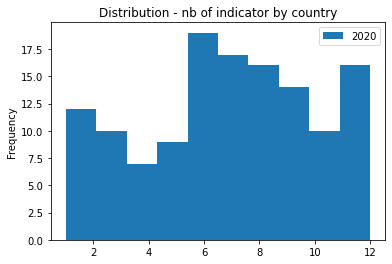

In [21]:
df_nb_indicators_by_country.plot(kind="hist", title="Distribution - nb of indicator by country");

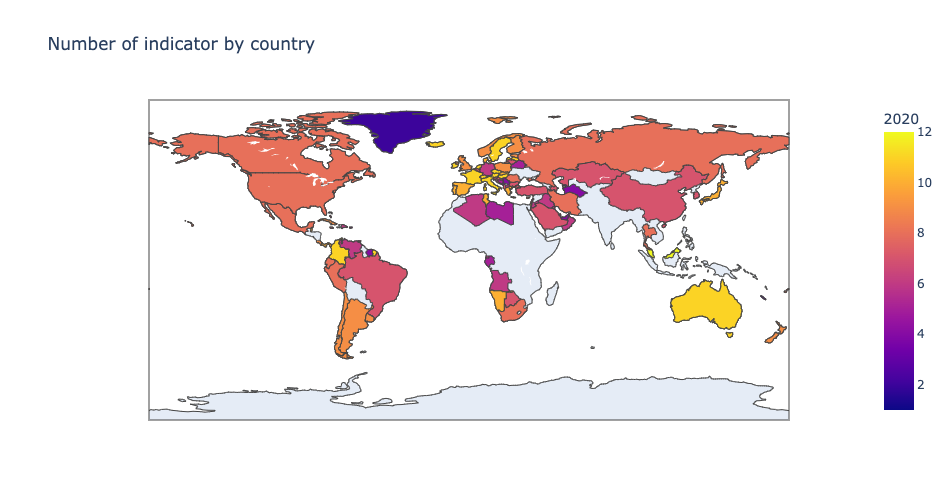

In [22]:
px.choropleth(df_nb_indicators_by_country,               
              locations="country_code",               
              color="2020",
              # hover_name="country_name",
              hover_data=["region", "country_name", "country_code"],
              animation_frame=None,    
              color_continuous_scale='Plasma',  
              height=500,
              width=None,
              title="Number of indicator by country",
              #range_color=(0, 12),
)

In [23]:
q1 = df_nb_indicators_by_country.quantile(.25).values[0]
q1

5.0

In [24]:
# country that have less than 5 indicators
less_than_1rs_quartile_indicators = df_nb_indicators_by_country.loc[df_nb_indicators_by_country["2020"] <= q1,
                                                                    "country_name"]
display(less_than_1rs_quartile_indicators)

data = data.loc[~data.country_name.isin(less_than_1rs_quartile_indicators)]

0                 American Samoa
5               French Polynesia
6                           Guam
7           Hong Kong SAR, China
12              Marshall Islands
13                 New Caledonia
15      Northern Mariana Islands
16                         Palau
17                     Singapore
20                        Tuvalu
22                       Andorra
25                       Belarus
27        Bosnia and Herzegovina
29               Channel Islands
35                 Faroe Islands
40                     Greenland
44                   Isle of Man
48                 Liechtenstein
52                        Monaco
53                    Montenegro
60                    San Marino
61                        Serbia
68                  Turkmenistan
77                Cayman Islands
82                       Curacao
83                      Dominica
86                       Grenada
91                   Puerto Rico
92     Sint Maarten (Dutch part)
95      St. Martin (French part)
97        

In [25]:
data.describe(include="all")

country_name country_code                       indicator_name  \
count          1104         1104                                 1104   
unique           92           92                                   12   
top        Thailand          BRB  Population, ages 15-64 (% of total)   
freq             12           12                                   92   
mean            NaN          NaN                                  NaN   
std             NaN          NaN                                  NaN   
min             NaN          NaN                                  NaN   
25%             NaN          NaN                                  NaN   
50%             NaN          NaN                                  NaN   
75%             NaN          NaN                                  NaN   
max             NaN          NaN                                  NaN   

           indicator_code          2020 short_name table_name  \
count                1104  7.650000e+02       1104       1104   
unique                 12           NaN         92         92   
top     SE.XPD.TOTL.GB.ZS           NaN   Thailand   Thailand   
freq                   92           NaN         12         12   
mean                  NaN  4.322576e+06        NaN        NaN   
std                   NaN  4.835398e+07        NaN        NaN   
min                   NaN  1.670000e-03        NaN        NaN   
25%                   NaN  7.281535e+00        NaN        NaN   
50%                   NaN  4.675612e+01        NaN        NaN   
75%                   NaN  1.122791e+02        NaN        NaN   
max                   NaN  1.262645e+09        NaN        NaN   

               long_name 2_alpha_code currency_unit  \
count               1104         1092          1104   
unique                92           91            72   
top     Kingdom of Tonga           OM          Euro   
freq                  12           12           204   
mean                 NaN          NaN           NaN   
std                  NaN          NaN           NaN   
min                  NaN          NaN           NaN   
25%                  NaN          NaN           NaN   
50%                  NaN          NaN           NaN   
75%                  NaN          NaN           NaN   
max                  NaN          NaN           NaN   

                                                                                                                                                   special_notes  \
count                                                                                                                                                        672   
unique                                                                                                                                                        49   
top     April 2012 database update: Based on official government statistics, national accounts data were revised for 2000 onward; the base year changed to 2006.   
freq                                                                                                                                                          48   
mean                                                                                                                                                         NaN   
std                                                                                                                                                          NaN   
min                                                                                                                                                          NaN   
25%                                                                                                                                                          NaN   
50%                                                                                                                                                          NaN   
75%                                             

### Analyze distribution of indicator by region

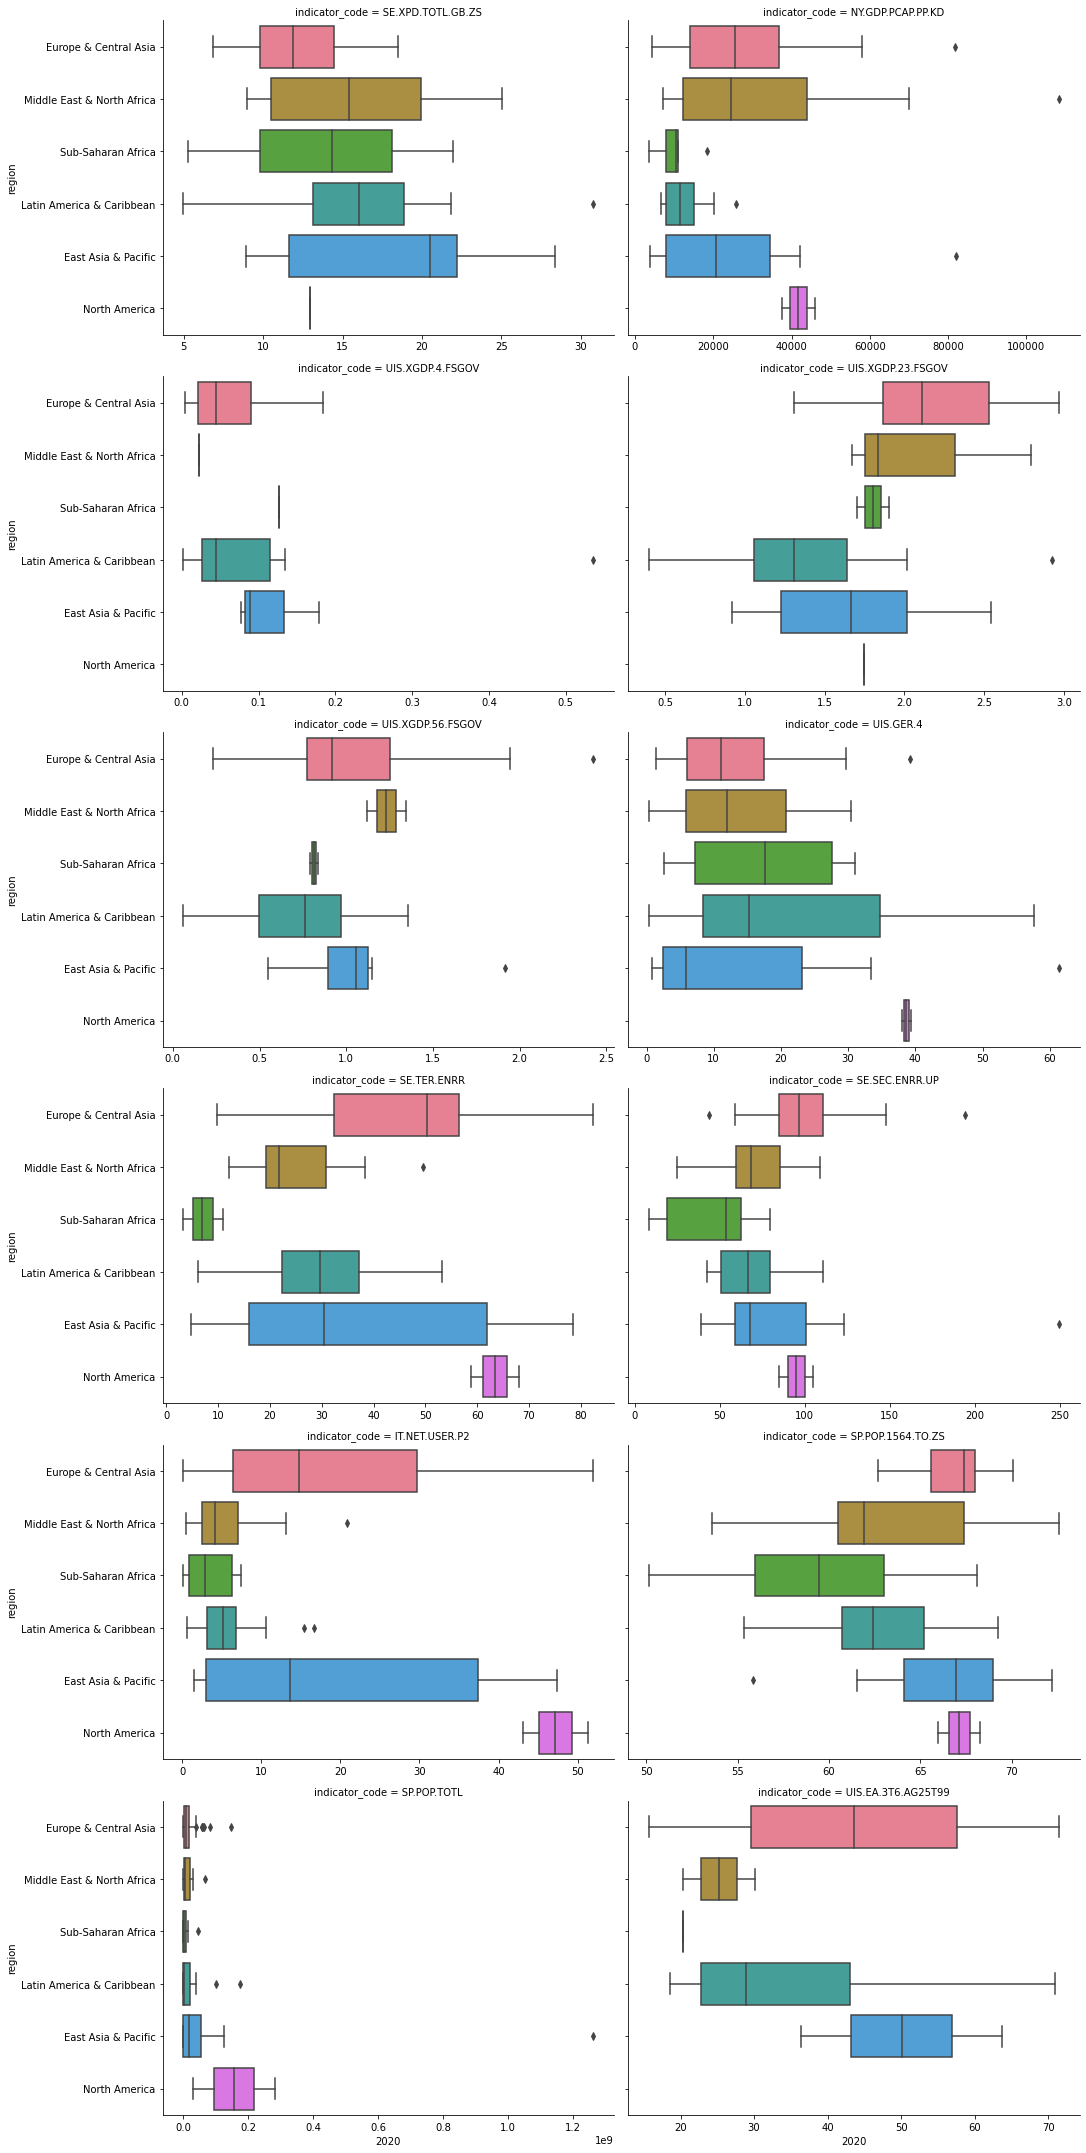

In [26]:
sns.catplot(data=data, y='region', x='2020', col='indicator_code',
            height=5, aspect=1.5, palette="husl", orient="h",
            col_wrap=2, kind="box", sharex=False, sharey=True);

### Topn of country by indicator

In [27]:
# topn (n=10) of country by indicator
TOPN = 10
df_country_by_indicator = (data
                           .groupby(['indicator_name'], as_index=True, dropna=False)
                           [['region', 'country_name', '2020']]
                           .apply(lambda x: x.nlargest(TOPN, columns=['2020'], keep="all"))
                           .reset_index()
                           )

df_country_by_indicator

indicator_name  \
0                                                     Expenditure on education as % of total government expenditure (%)   
1                                                     Expenditure on education as % of total government expenditure (%)   
2                                                     Expenditure on education as % of total government expenditure (%)   
3                                                     Expenditure on education as % of total government expenditure (%)   
4                                                     Expenditure on education as % of total government expenditure (%)   
..                                                                                                                  ...   
115  UIS: Percentage of population age 25+ with at least completed upper secondary education (ISCED 3 or higher). Total   
116  UIS: Percentage of population age 25+ with at least completed upper secondary education (ISCED 3 or higher). Total   
117  UIS: Percentage of population age 25+ with at least completed upper secondary education (ISCED 3 or higher). Total   
118  UIS: Percentage of population age 25+ with at least completed upper secondary education (ISCED 3 or higher). Total   
119  UIS: Percentage of population age 25+ with at least completed upper secondary education (ISCED 3 or higher). Total   

     level_1                      region                    country_name  \
0       2496   Latin America & Caribbean  St. Vincent and the Grenadines   
1       2604         East Asia & Pacific                        Thailand   
2       2664  Middle East & North Africa                         Tunisia   
3       2640         East Asia & Pacific                           Tonga   
4       1932          Sub-Saharan Africa                         Namibia   
..       ...                         ...                             ...   
115     2291  Middle East & North Africa                    Saudi Arabia   
116      503   Latin America & Caribbean                        Barbados   
117     1787  Middle East & North Africa                           Malta   
118     1823          Sub-Saharan Africa                       Mauritius   
119     1835   Latin America & Caribbean                          Mexico   

          2020  
0    30.789200  
1    28.388599  
2    25.047310  
3    22.955860  
4    21.925060  
..         ...  
115  30.066601  
116  24.205730  
117  20.398439  
118  20.398439  
119  18.577311  

[120 rows x 5 columns]

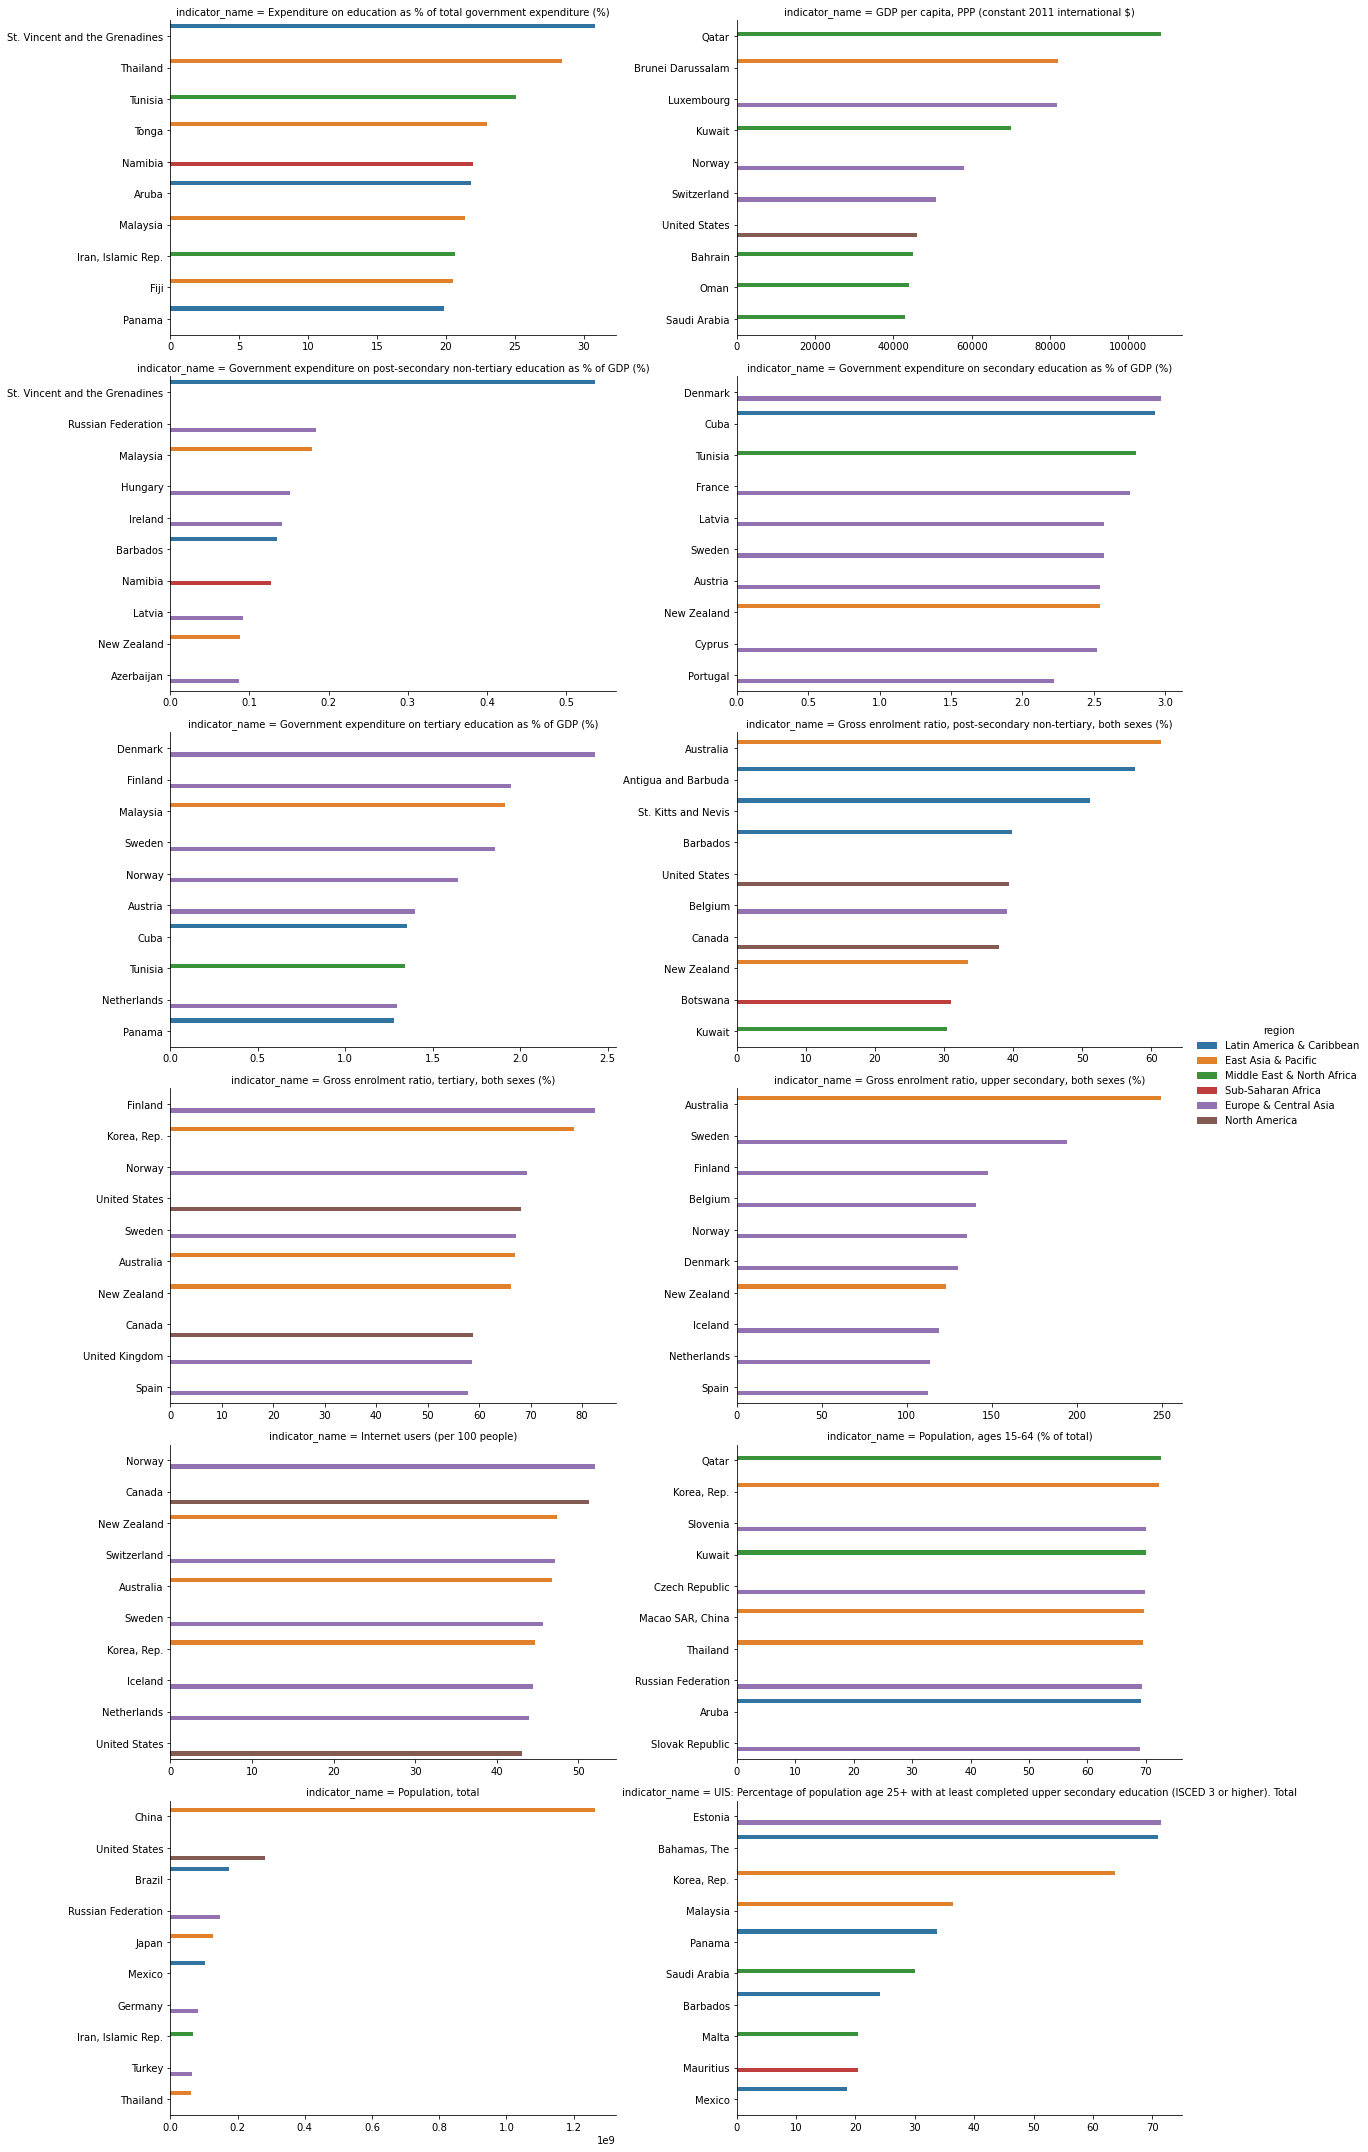

In [28]:
g = sns.catplot(data=df_country_by_indicator,
            y="country_name",
            x="2020",
            kind="bar",
            orient="h",
            height=5,
            aspect=1.7,
            hue="region",
            col="indicator_name",
            col_wrap=2,
            sharey=False,
            sharex=False,
           )
g.set_axis_labels("", "")

### Dirstribution of indicator

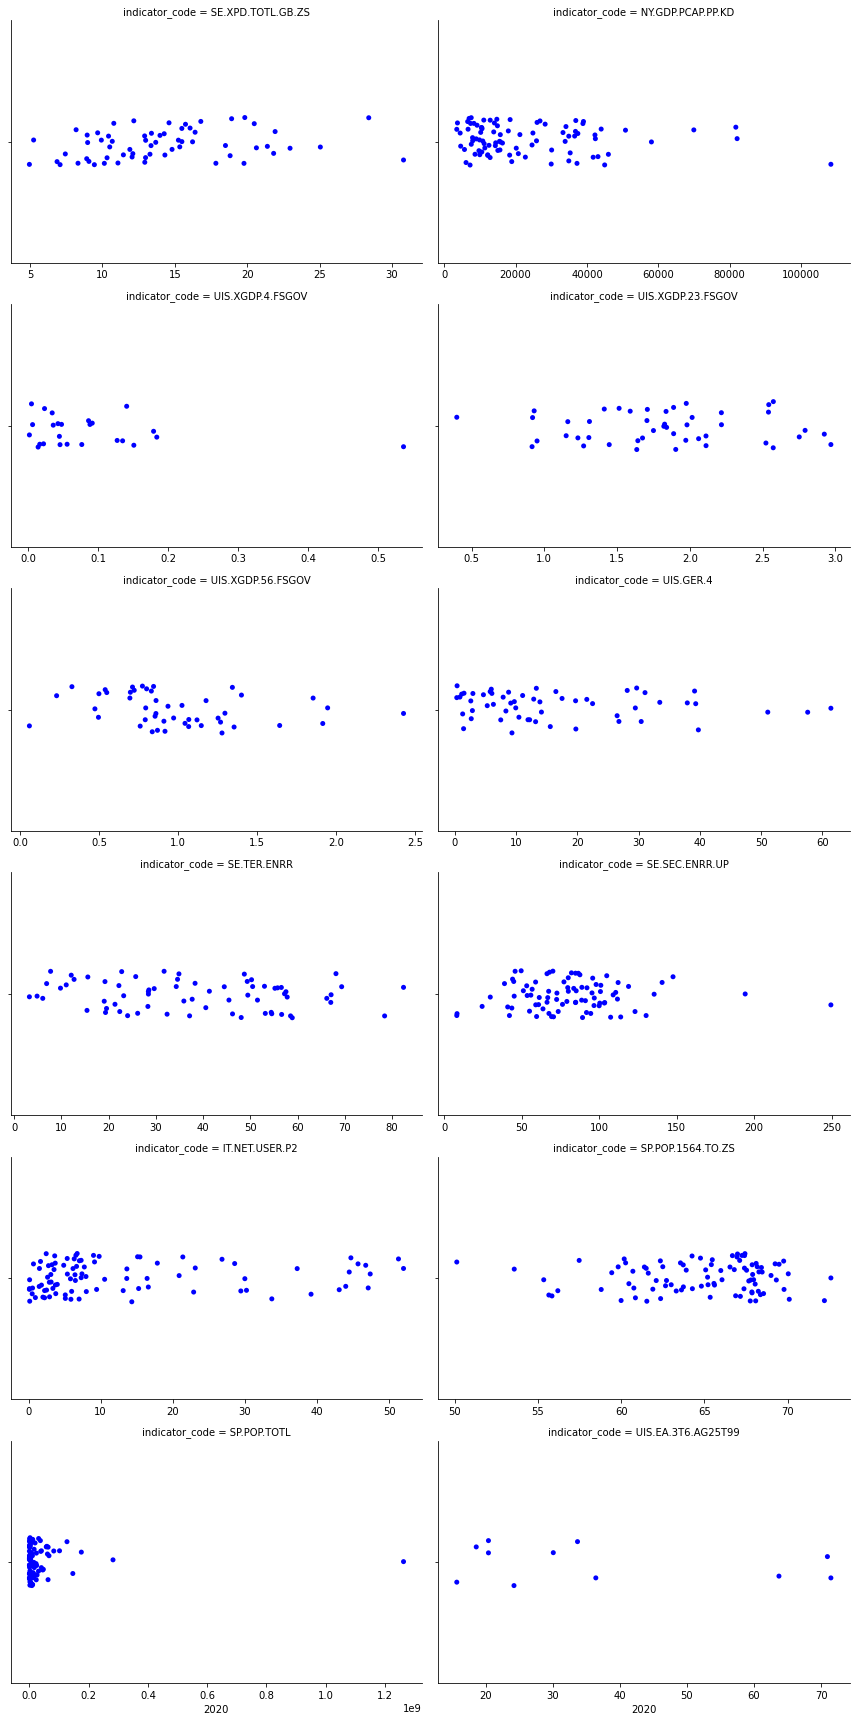

In [29]:
sns.catplot(data=data, 
            x="2020",
            col="indicator_code",
            kind="strip",
            orient="h",
            height=4,
            aspect=1.5,
            col_wrap=2,
            sharex=False,
            color="blue",
           );

## Create a new dataframe

Region, Country name & country code in row
indicator in columns

In [30]:
# Create a spreadsheet-style pivot table as a DataFrame.
data_pivot = pd.pivot_table(data=data,
                            index=["region", "country_name", "country_code"],
                            values='2020',
                            columns='indicator_code').reset_index()
print(f"Data shape: {data_pivot.shape}")
data_pivot.head()

Data shape: (92, 15)


indicator_code               region       country_name country_code  \
0               East Asia & Pacific          Australia          AUS   
1               East Asia & Pacific  Brunei Darussalam          BRN   
2               East Asia & Pacific              China          CHN   
3               East Asia & Pacific               Fiji          FJI   
4               East Asia & Pacific              Japan          JPN   

indicator_code  IT.NET.USER.P2  NY.GDP.PCAP.PP.KD  SE.SEC.ENRR.UP  \
0                    46.756116       35281.395362      249.607498   
1                     8.996285       82049.580860       67.462151   
2                     1.775913        3700.743648       38.959030   
3                     1.496855        6673.847391       59.116379   
4                    29.990740       33871.843545      100.454224   

indicator_code  SE.TER.ENRR  SE.XPD.TOTL.GB.ZS  SP.POP.1564.TO.ZS  \
0                  67.03891          13.360160          66.788576   
1                  12.69113           8.920740          66.955147   
2                   7.72048                NaN          68.462574   
3                       NaN          20.484921          61.538812   
4                  48.73653           9.930410          68.232188   

indicator_code   SP.POP.TOTL  UIS.EA.3T6.AG25T99  UIS.GER.4  \
0               1.915300e+07                 NaN  61.390049   
1               3.332410e+05                 NaN   1.296230   
2               1.262645e+09                 NaN   5.307240   
3               8.112230e+05                 NaN   2.885000   
4               1.268430e+08                 NaN   0.844730   

indicator_code  UIS.XGDP.23.FSGOV  UIS.XGDP.4.FSGOV  UIS.XGDP.56.FSGOV  
0                         1.88884           0.07649            1.14633  
1                             NaN               NaN                NaN  
2                             NaN               NaN                NaN  
3                             NaN               NaN            0.84457  
4                         1.44606               NaN            0.54858

In [31]:
data_pivot.describe(include="all")

indicator_code                 region  country_name country_code  \
count                              92            92           92   
unique                              6            92           92   
top             Europe & Central Asia  Saudi Arabia          BRB   
freq                               36             1            1   
mean                              NaN           NaN          NaN   
std                               NaN           NaN          NaN   
min                               NaN           NaN          NaN   
25%                               NaN           NaN          NaN   
50%                               NaN           NaN          NaN   
75%                               NaN           NaN          NaN   
max                               NaN           NaN          NaN   

indicator_code  IT.NET.USER.P2  NY.GDP.PCAP.PP.KD  SE.SEC.ENRR.UP  \
count                91.000000          90.000000       84.000000   
unique                     NaN                NaN             NaN   
top                        NaN                NaN             NaN   
freq                       NaN                NaN             NaN   
mean                 13.456444       23297.936342       81.920940   
std                  14.729495       18997.157329       35.704867   
min                   0.105046        3508.905125        8.165120   
25%                   3.180408       10260.927062       59.539659   
50%                   6.731396       15654.111790       80.134777   
75%                  17.225234       34689.708142       98.578098   
max                  52.000000      108323.903919      249.607498   

indicator_code  SE.TER.ENRR  SE.XPD.TOTL.GB.ZS  SP.POP.1564.TO.ZS  \
count             69.000000          63.000000          91.000000   
unique                  NaN                NaN                NaN   
top                     NaN                NaN                NaN   
freq                    NaN                NaN                NaN   
mean              38.041727          14.193053          64.749554   
std               19.611261           5.344908           4.236421   
min                3.234750           4.964300          50.130735   
25%               22.362659          10.375395          62.227768   
50%               37.147419          13.360160          65.567704   
75%               54.428761          16.599045          67.859249   
max               82.439072          30.789200          72.588714   

indicator_code   SP.POP.TOTL  UIS.EA.3T6.AG25T99  UIS.GER.4  \
count           9.200000e+01           11.000000  56.000000   
unique                   NaN                 NaN        NaN   
top                      NaN                 NaN        NaN   
freq                     NaN                 NaN        NaN   
mean            3.592016e+07           36.865614  16.628987   
std             1.359502e+08           21.497669  14.870619   
min             4.537400e+04           15.675070   0.335280   
25%             1.645501e+06           20.398439   5.921795   
50%             6.736625e+06           30.066601  12.091540   
75%             2.379614e+07           50.060844  26.575469   
max             1.262645e+09           71.459663  61.390049   

indicator_code  UIS.XGDP.23.FSGOV  UIS.XGDP.4.FSGOV  UIS.XGDP.56.FSGOV  
count                   46.000000         25.000000          47.000000  
unique                        NaN               NaN                NaN  
top                           NaN               NaN                NaN  
freq                          NaN               NaN                NaN  
mean                     1.814862          0.087523           0.983590  
std                      0.587587          0.108619           0.455717  
min                      0.397710          0.001670           0.059390  
25%                      1.420477          0.023290           0.741090  
50%                      1.831825          0.047550           0.869290  
75%                      2.111583     

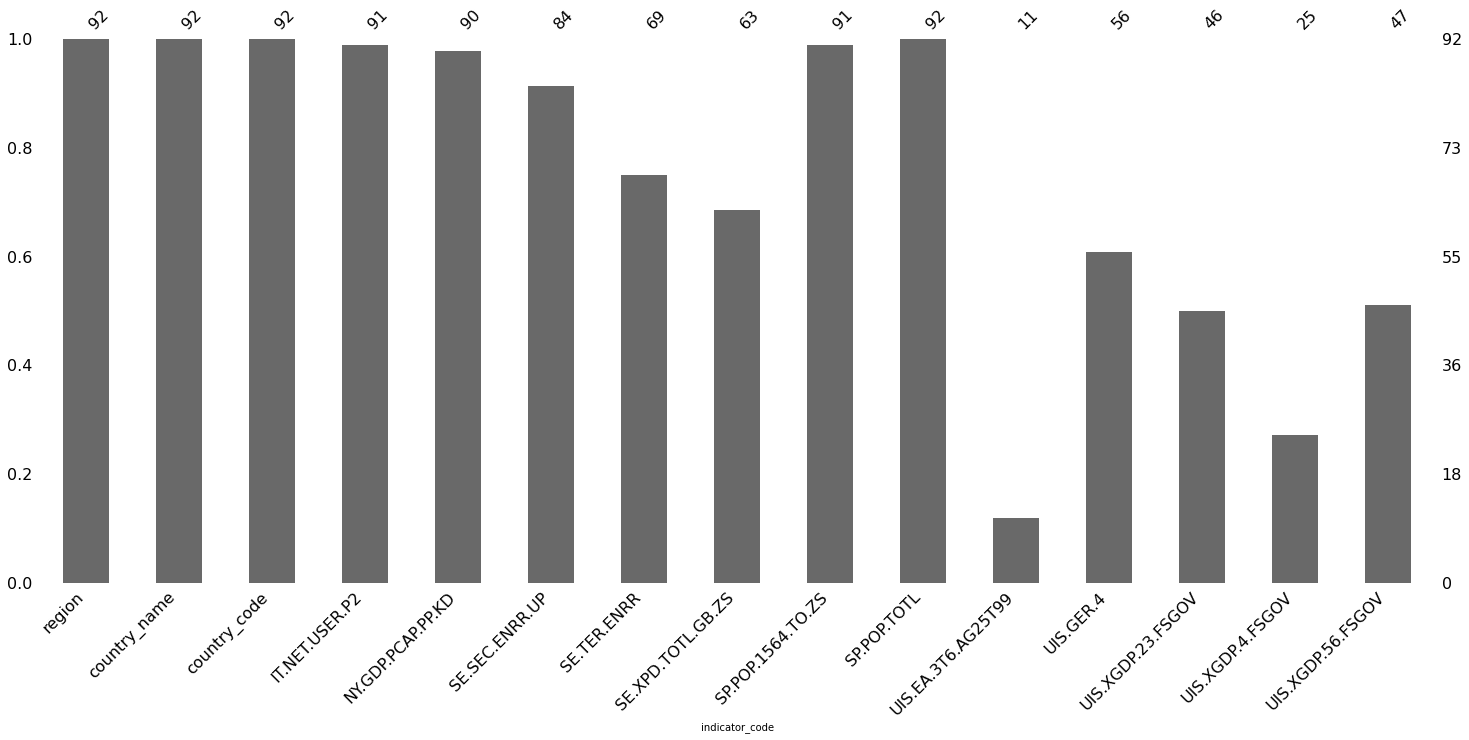

In [32]:
msno.bar(data_pivot);

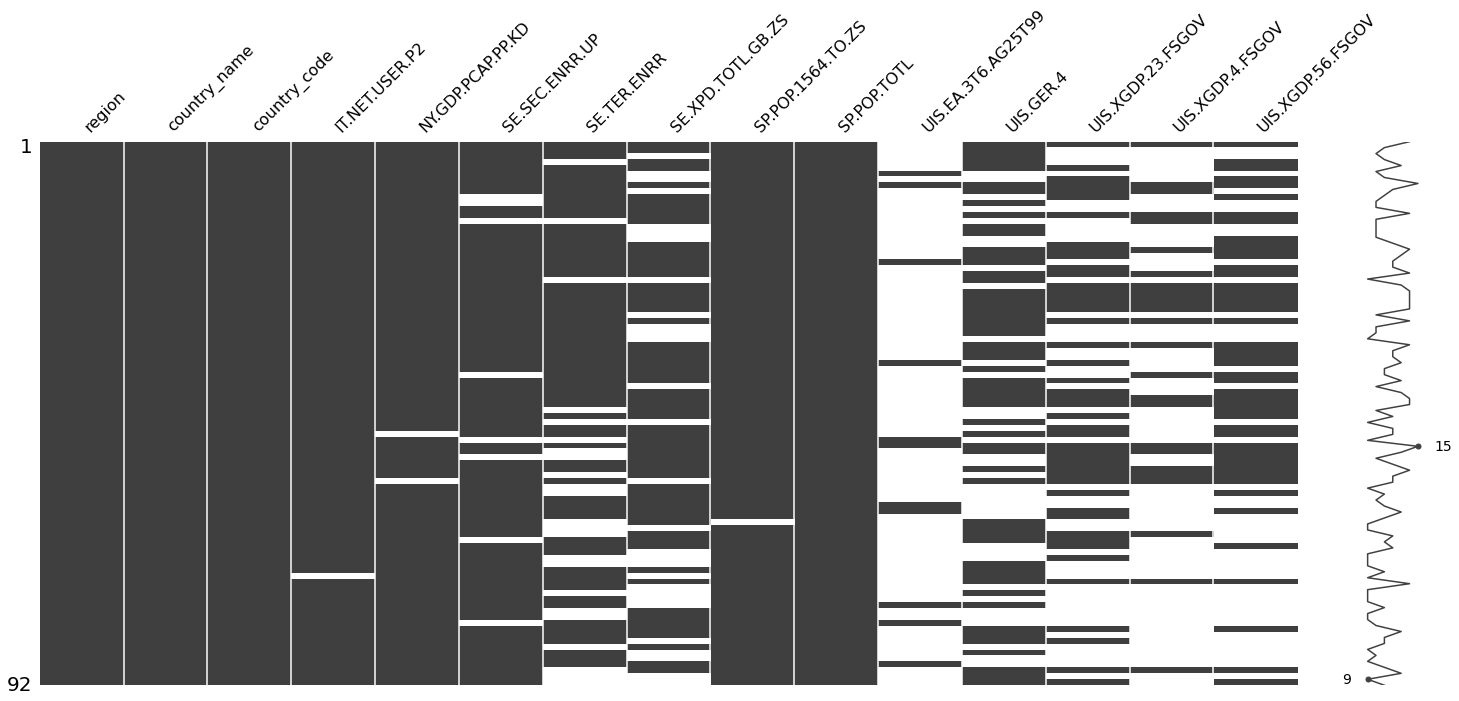

In [33]:
msno.matrix(data_pivot);

### Selected indicators / new ones created

In [34]:
#list of data_pivot selected indicators
indicators = ['IT.NET.USER.P2',  # internet
              "NY.GDP.PCAP.PP.KD", # GDP
              "SP.POP.1564.TO.ZS", # population
              # enrolment
              "SE.SEC.ENRR.UP",
              "SE.TER.ENRR",
              "UIS.GER.4",
              # expenditure
              "SE.XPD.TOTL.GB.ZS",
              "UIS.XGDP.23.FSGOV",
              "UIS.XGDP.4.FSGOV",
              "UIS.XGDP.56.FSGOV",
             ]
len(indicators)

10

### Create new features

In [35]:
data_pivot = (data_pivot
              .assign(total_enrolment=lambda dframe: dframe[["SE.SEC.ENRR.UP", "SE.TER.ENRR", "UIS.GER.4"]
                                                           ].mean(axis=1),
                      gov_expenditure=lambda dframe: (dframe["UIS.XGDP.23.FSGOV"]
                                                      + dframe["UIS.XGDP.4.FSGOV"]
                                                      + dframe["UIS.XGDP.56.FSGOV"]
                                                     ),
                     )
              .rename(columns={"SE.XPD.TOTL.GB.ZS": "percent_education_total_gov_expenditure",
                               "IT.NET.USER.P2": "internet_users",
                               "NY.GDP.PCAP.PP.KD": "gdp_per_capita"})
             )
data_pivot.head()

indicator_code               region       country_name country_code  \
0               East Asia & Pacific          Australia          AUS   
1               East Asia & Pacific  Brunei Darussalam          BRN   
2               East Asia & Pacific              China          CHN   
3               East Asia & Pacific               Fiji          FJI   
4               East Asia & Pacific              Japan          JPN   

indicator_code  internet_users  gdp_per_capita  SE.SEC.ENRR.UP  SE.TER.ENRR  \
0                    46.756116    35281.395362      249.607498     67.03891   
1                     8.996285    82049.580860       67.462151     12.69113   
2                     1.775913     3700.743648       38.959030      7.72048   
3                     1.496855     6673.847391       59.116379          NaN   
4                    29.990740    33871.843545      100.454224     48.73653   

indicator_code  percent_education_total_gov_expenditure  SP.POP.1564.TO.ZS  \
0                                             13.360160          66.788576   
1                                              8.920740          66.955147   
2                                                   NaN          68.462574   
3                                             20.484921          61.538812   
4                                              9.930410          68.232188   

indicator_code   SP.POP.TOTL  UIS.EA.3T6.AG25T99  UIS.GER.4  \
0               1.915300e+07                 NaN  61.390049   
1               3.332410e+05                 NaN   1.296230   
2               1.262645e+09                 NaN   5.307240   
3               8.112230e+05                 NaN   2.885000   
4               1.268430e+08                 NaN   0.844730   

indicator_code  UIS.XGDP.23.FSGOV  UIS.XGDP.4.FSGOV  UIS.XGDP.56.FSGOV  \
0                         1.88884           0.07649            1.14633   
1                             NaN               NaN                NaN   
2                             NaN               NaN                NaN   
3                             NaN               NaN            0.84457   
4                         1.44606               NaN            0.54858   

indicator_code  total_enrolment  gov_expenditure  
0                    126.012152          3.11166  
1                     27.149837              NaN  
2                     17.328917              NaN  
3                     31.000689              NaN  
4                     50.011828              NaN

### EDA for new indicators

In [36]:
url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data'
country_geo = f'{url}/world-countries.json'

In [62]:
for col_name in ['internet_users',
                 "gdp_per_capita",
                 "total_enrolment",
                 "gov_expenditure",
                 "percent_education_total_gov_expenditure",
                ]:
    m = folium.Map(location=[0, 0], zoom_start=1)
    folium.Choropleth(geo_data=country_geo,
                  data=data_pivot,
                  columns=['country_code', col_name],
                  key_on='feature.id',
                  name="choropleth",
                  fill_color='BuPu',
                  fill_opacity=0.7,
                  line_opacity=0.2,
                  legend_name=col_name,
                  nan_fill_color="black",
                  highlight=True,
                 ).add_to(m)
    display(m)

In [38]:
data_pivot.head()

indicator_code               region       country_name country_code  \
0               East Asia & Pacific          Australia          AUS   
1               East Asia & Pacific  Brunei Darussalam          BRN   
2               East Asia & Pacific              China          CHN   
3               East Asia & Pacific               Fiji          FJI   
4               East Asia & Pacific              Japan          JPN   

indicator_code  internet_users  gdp_per_capita  SE.SEC.ENRR.UP  SE.TER.ENRR  \
0                    46.756116    35281.395362      249.607498     67.03891   
1                     8.996285    82049.580860       67.462151     12.69113   
2                     1.775913     3700.743648       38.959030      7.72048   
3                     1.496855     6673.847391       59.116379          NaN   
4                    29.990740    33871.843545      100.454224     48.73653   

indicator_code  percent_education_total_gov_expenditure  SP.POP.1564.TO.ZS  \
0                                             13.360160          66.788576   
1                                              8.920740          66.955147   
2                                                   NaN          68.462574   
3                                             20.484921          61.538812   
4                                              9.930410          68.232188   

indicator_code   SP.POP.TOTL  UIS.EA.3T6.AG25T99  UIS.GER.4  \
0               1.915300e+07                 NaN  61.390049   
1               3.332410e+05                 NaN   1.296230   
2               1.262645e+09                 NaN   5.307240   
3               8.112230e+05                 NaN   2.885000   
4               1.268430e+08                 NaN   0.844730   

indicator_code  UIS.XGDP.23.FSGOV  UIS.XGDP.4.FSGOV  UIS.XGDP.56.FSGOV  \
0                         1.88884           0.07649            1.14633   
1                             NaN               NaN                NaN   
2                             NaN               NaN                NaN   
3                             NaN               NaN            0.84457   
4                         1.44606               NaN            0.54858   

indicator_code  total_enrolment  gov_expenditure  
0                    126.012152          3.11166  
1                     27.149837              NaN  
2                     17.328917              NaN  
3                     31.000689              NaN  
4                     50.011828              NaN

## Scoring

In [39]:
# list of indicator to measure attractiviness score

list_features = ["internet_users",
                 "gdp_per_capita",
                 "total_enrolment",
                 "percent_education_total_gov_expenditure",
                ]

### Scenario 1: Custom weighted

In [40]:
# internet users stats
internet_stat = data_pivot["internet_users"].describe(percentiles=np.arange(0, 1, 0.1))
internet_stat

count    91.000000
mean     13.456444
std      14.729495
min       0.105046
0%        0.105046
10%       1.496855
20%       2.750740
30%       3.689041
40%       5.800253
50%       6.731396
60%       8.996285
70%      15.110260
80%      23.110874
90%      43.079163
max      52.000000
Name: internet_users, dtype: float64

In [41]:
# filter out all coutries that have internet_users less thant 80% decile
data_custom = data_pivot.loc[data_pivot["internet_users"] >= internet_stat.loc["70%"], :].copy()
data_custom.country_name.unique()

array(['Australia', 'Japan', 'Korea, Rep.', 'Malaysia', 'New Zealand',
       'Austria', 'Belgium', 'Cyprus', 'Denmark', 'Estonia', 'Finland',
       'Germany', 'Iceland', 'Ireland', 'Italy', 'Luxembourg',
       'Netherlands', 'Norway', 'Portugal', 'Slovenia', 'Sweden',
       'Switzerland', 'United Kingdom', 'Aruba', 'Chile', 'Israel',
       'Canada', 'United States'], dtype=object)

In [42]:
data_custom.head()

indicator_code               region country_name country_code  internet_users  \
0               East Asia & Pacific    Australia          AUS       46.756116   
4               East Asia & Pacific        Japan          JPN       29.990740   
5               East Asia & Pacific  Korea, Rep.          KOR       44.700000   
7               East Asia & Pacific     Malaysia          MYS       21.384731   
8               East Asia & Pacific  New Zealand          NZL       47.379557   

indicator_code  gdp_per_capita  SE.SEC.ENRR.UP  SE.TER.ENRR  \
0                 35281.395362      249.607498    67.038910   
4                 33871.843545      100.454224    48.736530   
5                 20756.779897       95.884689    78.436157   
7                 16309.967988       45.810822    25.742260   
8                 28264.565116      123.198380    66.192177   

indicator_code  percent_education_total_gov_expenditure  SP.POP.1564.TO.ZS  \
0                                              13.36016          66.788576   
4                                               9.93041          68.232188   
5                                                   NaN          72.199592   
7                                              21.39068          62.719942   
8                                                   NaN          65.468325   

indicator_code  SP.POP.TOTL  UIS.EA.3T6.AG25T99  UIS.GER.4  UIS.XGDP.23.FSGOV  \
0                19153000.0                 NaN  61.390049            1.88884   
4               126843000.0                 NaN   0.844730            1.44606   
5                47008111.0           63.714600        NaN                NaN   
7                23185608.0           36.407089  19.770599            2.06063   
8                 3857700.0                 NaN  33.464970            2.54104   

indicator_code  UIS.XGDP.4.FSGOV  UIS.XGDP.56.FSGOV  total_enrolment  \
0                        0.07649            1.14633       126.012152   
4                            NaN            0.54858        50.011828   
5                            NaN                NaN        87.160423   
7                        0.17907            1.91465        30.441227   
8                        0.08818                NaN        74.285175   

indicator_code  gov_expenditure  
0                       3.11166  
4                           NaN  
5                           NaN  
7                       4.15435  
8                           NaN

In [43]:
# higher value, higher percentile rank

data_custom.loc[:, list_features] = data_custom.loc[:, list_features
                                                   ].rank(pct=True, ascending=True, na_option="keep") * 100

data_custom.head()

indicator_code               region country_name country_code  internet_users  \
0               East Asia & Pacific    Australia          AUS       85.714286   
4               East Asia & Pacific        Japan          JPN       50.000000   
5               East Asia & Pacific  Korea, Rep.          KOR       78.571429   
7               East Asia & Pacific     Malaysia          MYS       28.571429   
8               East Asia & Pacific  New Zealand          NZL       92.857143   

indicator_code  gdp_per_capita  SE.SEC.ENRR.UP  SE.TER.ENRR  \
0                    51.851852      249.607498    67.038910   
4                    40.740741      100.454224    48.736530   
5                    14.814815       95.884689    78.436157   
7                    11.111111       45.810822    25.742260   
8                    29.629630      123.198380    66.192177   

indicator_code  percent_education_total_gov_expenditure  SP.POP.1564.TO.ZS  \
0                                             52.380952          66.788576   
4                                              9.523810          68.232188   
5                                                   NaN          72.199592   
7                                             95.238095          62.719942   
8                                                   NaN          65.468325   

indicator_code  SP.POP.TOTL  UIS.EA.3T6.AG25T99  UIS.GER.4  UIS.XGDP.23.FSGOV  \
0                19153000.0                 NaN  61.390049            1.88884   
4               126843000.0                 NaN   0.844730            1.44606   
5                47008111.0           63.714600        NaN                NaN   
7                23185608.0           36.407089  19.770599            2.06063   
8                 3857700.0                 NaN  33.464970            2.54104   

indicator_code  UIS.XGDP.4.FSGOV  UIS.XGDP.56.FSGOV  total_enrolment  \
0                        0.07649            1.14633       100.000000   
4                            NaN            0.54858        21.428571   
5                            NaN                NaN        89.285714   
7                        0.17907            1.91465         3.571429   
8                        0.08818                NaN        78.571429   

indicator_code  gov_expenditure  
0                       3.11166  
4                           NaN  
5                           NaN  
7                       4.15435  
8                           NaN

In [44]:
def scoring(dframe: pd.DataFrame,
           features_weight: Dict[str, float]
           ) -> float:
    """ Country attractivity score
    
    Args:
        dframe (pd.DataFrame): data frame
    
    Returns:
        float: attractivity score
    
    """
    score = 0
    for col_name, weight in features_weight.items():
        score += weight * dframe[col_name]
        
    return score

In [45]:
# custom weighted

weigthed = {"internet_users": .4,
            "total_enrolment": .25,
            "gdp_per_capita": .25,
            "percent_education_total_gov_expenditure": .1,
           }


data_custom = (data_custom
               .assign(attractivity_score_custom=
                       lambda dframe: dframe.apply(scoring, features_weight=weigthed, axis=1))
               .reset_index()
              )
data_custom[list_features + ["attractivity_score_custom"]].head()

indicator_code  internet_users  gdp_per_capita  total_enrolment  \
0                    85.714286       51.851852       100.000000   
1                    50.000000       40.740741        21.428571   
2                    78.571429       14.814815        89.285714   
3                    28.571429       11.111111         3.571429   
4                    92.857143       29.629630        78.571429   

indicator_code  percent_education_total_gov_expenditure  \
0                                             52.380952   
1                                              9.523810   
2                                                   NaN   
3                                             95.238095   
4                                                   NaN   

indicator_code  attractivity_score_custom  
0                               77.486772  
1                               36.494709  
2                                     NaN  
3                               24.623016  
4                                     NaN

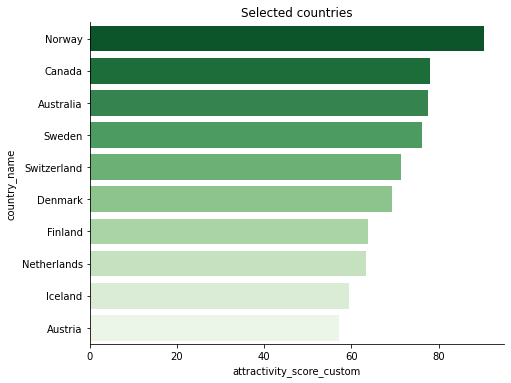

In [46]:
top_country_custom = data_custom.nlargest(TOPN, columns=["attractivity_score_custom"], keep="all")
g = sns.catplot(data=top_country_custom,
                kind="bar", orient="h", hue=None,
                y="country_name", x="attractivity_score_custom", estimator=np.mean,
                height=5, aspect=1.4, palette="Greens_r",
               )
g.ax.set_title("Selected countries");

### Scenario 2: Statistical method

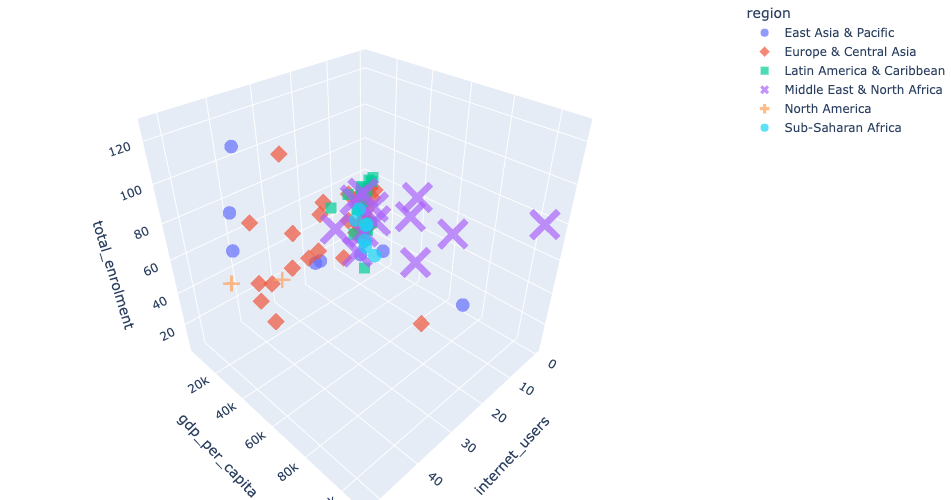

In [47]:
fig = px.scatter_3d(data_frame=data_pivot,
                    x="internet_users",
                    y="gdp_per_capita",
                    z='total_enrolment',
                    color='region',
                    hover_name="country_name",
                    symbol='region',
                    opacity=0.7,
                    width=800,
                    height=500,
                   )
# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

In [48]:
def fillna_by_group(data, groupby, columns, estimator="median"):
    """ Fill na by group
    
    Args:
        data (pd.DataFrame):
        groupby (Union[str, Sequence[str]]):
        columns (Union[str, Sequence[str]]):
        estimator (str):
    
    Return:
        pd.DataFrame
    
    """
    return data_pivot[columns].fillna(data_pivot.groupby(groupby)[columns].transform(estimator))

In [49]:
# Fille na values

data_pivot[list_features] = fillna_by_group(data=data_pivot,
                                            groupby="region",
                                            columns=list_features,
                                            estimator="median",
                                           )
data_pivot.head()

indicator_code               region       country_name country_code  \
0               East Asia & Pacific          Australia          AUS   
1               East Asia & Pacific  Brunei Darussalam          BRN   
2               East Asia & Pacific              China          CHN   
3               East Asia & Pacific               Fiji          FJI   
4               East Asia & Pacific              Japan          JPN   

indicator_code  internet_users  gdp_per_capita  SE.SEC.ENRR.UP  SE.TER.ENRR  \
0                    46.756116    35281.395362      249.607498     67.03891   
1                     8.996285    82049.580860       67.462151     12.69113   
2                     1.775913     3700.743648       38.959030      7.72048   
3                     1.496855     6673.847391       59.116379          NaN   
4                    29.990740    33871.843545      100.454224     48.73653   

indicator_code  percent_education_total_gov_expenditure  SP.POP.1564.TO.ZS  \
0                                             13.360160          66.788576   
1                                              8.920740          66.955147   
2                                             20.484921          68.462574   
3                                             20.484921          61.538812   
4                                              9.930410          68.232188   

indicator_code   SP.POP.TOTL  UIS.EA.3T6.AG25T99  UIS.GER.4  \
0               1.915300e+07                 NaN  61.390049   
1               3.332410e+05                 NaN   1.296230   
2               1.262645e+09                 NaN   5.307240   
3               8.112230e+05                 NaN   2.885000   
4               1.268430e+08                 NaN   0.844730   

indicator_code  UIS.XGDP.23.FSGOV  UIS.XGDP.4.FSGOV  UIS.XGDP.56.FSGOV  \
0                         1.88884           0.07649            1.14633   
1                             NaN               NaN                NaN   
2                             NaN               NaN                NaN   
3                             NaN               NaN            0.84457   
4                         1.44606               NaN            0.54858   

indicator_code  total_enrolment  gov_expenditure  
0                    126.012152          3.11166  
1                     27.149837              NaN  
2                     17.328917              NaN  
3                     31.000689              NaN  
4                     50.011828              NaN

In [50]:
scaled_data = pd.DataFrame(MinMaxScaler().fit_transform(data_pivot[list_features]),
                           columns=list_features,
                           index=pd.MultiIndex.from_frame(data_pivot[["region", "country_name", "country_code"]]))
scaled_data

internet_users  \
region              country_name      country_code                   
East Asia & Pacific Australia         AUS                 0.898952   
                    Brunei Darussalam BRN                 0.171331   
                    China             CHN                 0.032197   
                    Fiji              FJI                 0.026820   
                    Japan             JPN                 0.575888   
...                                                            ...   
Sub-Saharan Africa  Equatorial Guinea GNQ                 0.000526   
                    Mauritius         MUS                 0.138289   
                    Namibia           NAM                 0.029669   
                    Seychelles        SYC                 0.140487   
                    South Africa      ZAF                 0.101041   

                                                    gdp_per_capita  \
region              country_name      country_code                   
East Asia & Pacific Australia         AUS                 0.303129   
                    Brunei Darussalam BRN                 0.749327   
                    China             CHN                 0.001830   
                    Fiji              FJI                 0.030196   
                    Japan             JPN                 0.289681   
...                                                            ...   
Sub-Saharan Africa  Equatorial Guinea GNQ                 0.069492   
                    Mauritius         MUS                 0.072206   
                    Namibia           NAM                 0.024779   
                    Seychelles        SYC                 0.142577   
                    South Africa      ZAF                 0.059216   

                                                    total_enrolment  \
region              country_name      country_code                    
East Asia & Pacific Australia         AUS                  1.000000   
                    Brunei Darussalam BRN                  0.179070   
                    China             CHN                  0.097519   
                    Fiji              FJI                  0.211046   
                    Japan             JPN                  0.368910   
...                                                             ...   
Sub-Saharan Africa  Equatorial Guinea GNQ                  0.000954   
                    Mauritius         MUS                  0.281844   
                    Namibia           NAM                  0.088199   
                    Seychelles        SYC                  0.286187   
                    South Africa      ZAF                  0.321362   

                                                    percent_education_total_gov_expenditure  
region              country_name      country_code                                           
East Asia & Pacific Australia         AUS                                          0.325107  
                    Brunei Darussalam BRN                                          0.153203  
                    China             CHN                                          0.600994  
                    Fiji              FJI                                          0.600994  
                    Japan             JPN                                          0.192299  
...                                                                                     ...  
Sub-Saharan Africa  Equatorial Guinea GNQ                                          0.362172  
                    Mauritius         MUS                                          0.362172  
                    Namibia           NAM                                          0.656760  
                    Seychelles        SYC                                          0.362172  
                    South Africa      ZAF                                          0.362172  

[92 rows x 4 columns]

In [51]:
pca = PCA(n_components=None)
pca.fit(scaled_data)   
explain_var_ratio = pca.explained_variance_ratio_
explain_var_ratio

array([0.59491999, 0.20313471, 0.11460959, 0.08733571])

In [52]:
# weighted: explain variance of each component multiply by the coordinate of feature
weighted = sum(np.multiply(explain_var_ratio.reshape(1, -1).T, pca.components_))
# normalized weight: sum of weigth will be equal to 1
normalize_weighted =  (weighted / sum(weighted)).round(2)
features_weight_stat = dict(zip(list_features, normalize_weighted))

features_weight_stat

{'internet_users': 0.43,
 'gdp_per_capita': 0.23,
 'total_enrolment': 0.2,
 'percent_education_total_gov_expenditure': 0.15}

In [53]:
data_pivot[list_features]

indicator_code  internet_users  gdp_per_capita  total_enrolment  \
0                    46.756116    35281.395362       126.012152   
1                     8.996285    82049.580860        27.149837   
2                     1.775913     3700.743648        17.328917   
3                     1.496855     6673.847391        31.000689   
4                    29.990740    33871.843545        50.011828   
..                         ...             ...              ...   
87                    0.132355    10792.733023         5.699935   
88                    7.281535    11077.147618        39.526619   
89                    1.644740     6106.108164        16.206575   
90                    7.395629    18453.109771        40.049661   
91                    5.348560     9715.620644        44.285725   

indicator_code  percent_education_total_gov_expenditure  
0                                             13.360160  
1                                              8.920740  
2                                             20.484921  
3                                             20.484921  
4                                              9.930410  
..                                                  ...  
87                                            14.317360  
88                                            14.317360  
89                                            21.925060  
90                                            14.317360  
91                                            14.317360  

[92 rows x 4 columns]

In [54]:
scaled_data = (scaled_data
               .assign(attractivity_score=
                       lambda dframe: dframe.apply(scoring, features_weight=features_weight_stat, axis=1))
               .reset_index()
              )
scaled_data

region       country_name country_code  internet_users  \
0   East Asia & Pacific          Australia          AUS        0.898952   
1   East Asia & Pacific  Brunei Darussalam          BRN        0.171331   
2   East Asia & Pacific              China          CHN        0.032197   
3   East Asia & Pacific               Fiji          FJI        0.026820   
4   East Asia & Pacific              Japan          JPN        0.575888   
..                  ...                ...          ...             ...   
87   Sub-Saharan Africa  Equatorial Guinea          GNQ        0.000526   
88   Sub-Saharan Africa          Mauritius          MUS        0.138289   
89   Sub-Saharan Africa            Namibia          NAM        0.029669   
90   Sub-Saharan Africa         Seychelles          SYC        0.140487   
91   Sub-Saharan Africa       South Africa          ZAF        0.101041   

    gdp_per_capita  total_enrolment  percent_education_total_gov_expenditure  \
0         0.303129         1.000000                                 0.325107   
1         0.749327         0.179070                                 0.153203   
2         0.001830         0.097519                                 0.600994   
3         0.030196         0.211046                                 0.600994   
4         0.289681         0.368910                                 0.192299   
..             ...              ...                                      ...   
87        0.069492         0.000954                                 0.362172   
88        0.072206         0.281844                                 0.362172   
89        0.024779         0.088199                                 0.656760   
90        0.142577         0.286187                                 0.362172   
91        0.059216         0.321362                                 0.362172   

    attractivity_score  
0             0.705035  
1             0.304812  
2             0.123919  
3             0.150836  
4             0.416886  
..                 ...  
87            0.070726  
88            0.186766  
89            0.134611  
90            0.204765  
91            0.175665  

[92 rows x 8 columns]

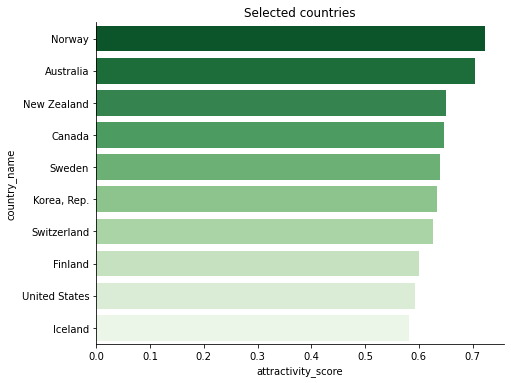

In [55]:
top_country = scaled_data.nlargest(TOPN, columns=["attractivity_score"], keep="all")
g = sns.catplot(data=top_country,
                kind="bar", orient="h", hue=None,
                y="country_name", x="attractivity_score", estimator=np.mean,
                height=5, aspect=1.4, palette="Greens_r",
               )
g.ax.set_title("Selected countries") ;

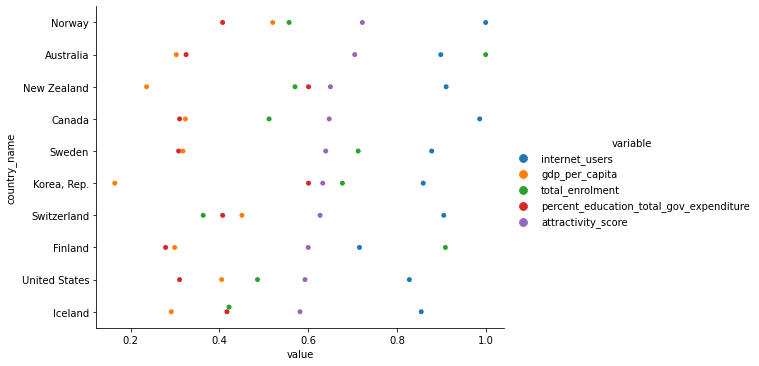

In [56]:
(pd.melt(top_country,
        id_vars=["country_name", "region"],
        value_vars=list_features + ["attractivity_score"],
        var_name=None,
        value_name='value',)
 .pipe((sns.catplot, "data"), kind="swarm",
       y="country_name", x="value", hue="variable", height=5, aspect=1.5
      )
);

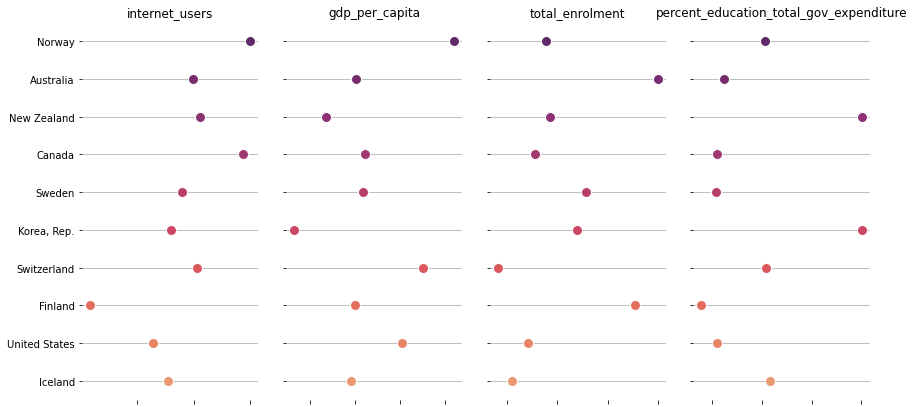

In [57]:
g = sns.PairGrid(top_country,
                 x_vars=list_features, y_vars=["country_name"],
                 height=6, aspect=.5,
                )

# Stripplot
g.map(sns.stripplot, size=10, orient="h", jitter=False,
      palette="flare_r", linewidth=1, edgecolor="w")


titles = list_features

# Labels
g.set(xlabel="", ylabel="")

for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)
    ax.set_xticklabels([])

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)
sns.despine(left=True, bottom=True)

In [58]:
# top of region
scaled_data.groupby("region").attractivity_score.mean().nlargest(n=10)

region
North America                 0.620367
East Asia & Pacific           0.366177
Europe & Central Asia         0.332619
Middle East & North Africa    0.240436
Latin America & Caribbean     0.197159
Sub-Saharan Africa            0.130659
Name: attractivity_score, dtype: float64

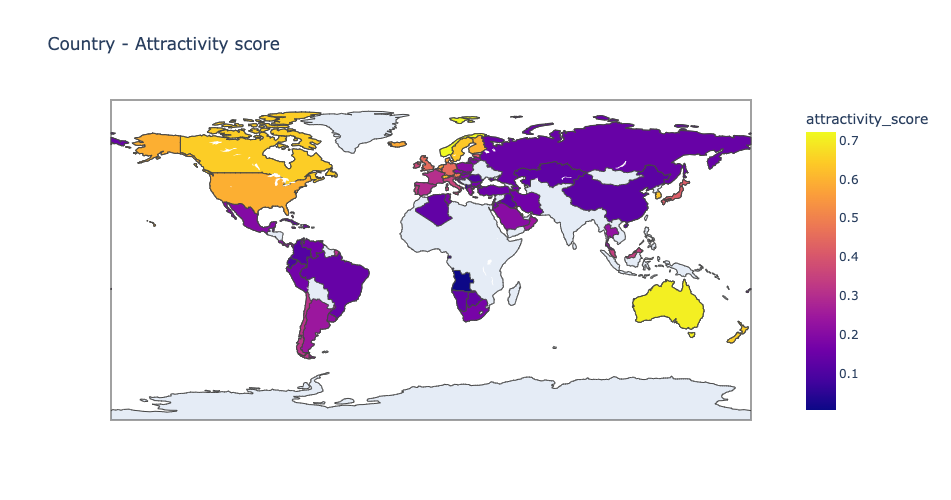

In [59]:
fig= px.choropleth(scaled_data.reset_index(),               
              locations="country_code",               
              color="attractivity_score",
              # hover_name="country_name",
              hover_data=["region", "country_name"],
              animation_frame=None,    
              color_continuous_scale='Plasma',  
              height=500,
              width=None,
              title="Country - Attractivity score",
              #range_color=(0, 12),
)
fig.show()
fig.write_image("images/map_attractivity.png")

/Users/mouslydiaw/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:3805: UserWarning:

Setting `sharey=False` with `color=None` may cause different levels of the `y` variable to share colors. This will change in a future version.



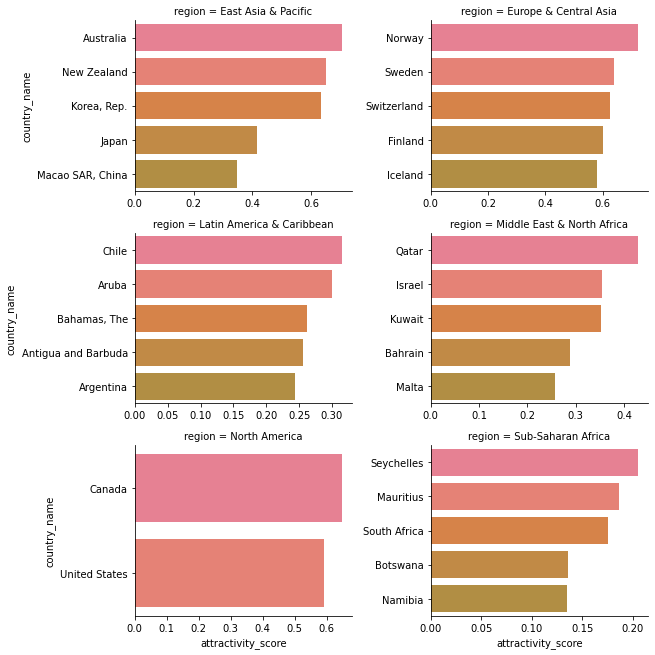

In [60]:
#top5 of country byy Region
g = (scaled_data.groupby("region", as_index=False)
     .apply(lambda g: g.nlargest(5, columns=["attractivity_score"], keep="all"))
     .pipe((sns.catplot, "data"), 
           kind="bar", orient="h", col="region", col_wrap=2,
           y="country_name", x="attractivity_score", estimator=np.mean,
           height=3, aspect=1.5, palette="husl", sharex=False, sharey=False
          )
    )
# save fig
plt.savefig("images/top_country_per_region.png")